In [1]:
import math
import scipy
import numpy as np
import skfuzzy as fuzz
from pyemd import emd
from sklearn import metrics
from scipy.stats import norm
from matplotlib import pyplot as plt
from scipy.spatial.distance import cosine, jaccard

# Similarity Metrics
## Euclidean
$S_E = \sqrt{\sum_{x \in X}{(P(x)-Q(x))^2}} $

## Jaccard
$D_J = \sum_{x \in X}{\frac{min(P(x),Q(x))}{max(P(x),Q(x))}} $

$S_J = \frac{1}{(1+D_J)}$

## Alpha Intervals
Calculate Jaccard interval similarity at different alpha-cuts

In [2]:
def euclidean(P, Q):
    '''Euclidean Distance converted to Similarity'''
    if (len(P) != len(Q)): # ensure they are equal length
        raise ValueError('P and Q must be the same length')
    dist = np.sqrt(np.sum(np.square(P-Q)))
    #return 1/math.exp(dist)
    return 1/(1+dist)

def jaccard(P, Q):
    '''Jaccard Similarity'''
    if (len(P) != len(Q)): # ensure they are equal length
        raise ValueError('P and Q must be the same length')
    num = np.sum(np.minimum(P,Q))
    den = np.sum(np.maximum(P,Q))
    return num/den

def alpha_ints(P, Q):
    if (len(P) != len(Q)): # ensure they are equal length
        raise ValueError('P and Q must be the same length')
    start_cut = 0
    end_cut = np.maximum(np.amax(P),np.amax(Q))
    gap = 0.1
    jaccard = np.array([])

    for yalpha in np.arange(start_cut,end_cut,gap):
        # for this alpha-cut value at yalpha
        P_ys = np.where(P>yalpha)
        Q_ys = np.where(Q>yalpha)
        if len(P_ys[0]) > 0:
            x1 = P_ys[0][0]
            x0 = x1 - 1
            Pleft = x0 + (yalpha-P[x0])*(x1-x0)/(P[x1]-P[x0])
            x0 = P_ys[0][-1]
            x1 = x0 + 1
            Pright = x0 + (yalpha-P[x0])*(x1-x0)/(P[x1]-P[x0])
        else:
            Pleft = 0
            Pright = 0

        if len(Q_ys[0]) > 0:
            x1 = Q_ys[0][0]
            x0 = x1 - 1
            Qleft = x0 + (yalpha-Q[x0])*(x1-x0)/(Q[x1]-Q[x0])
            x0 = Q_ys[0][-1]
            x1 = x0 + 1
            Qright = x0 + (yalpha-Q[x0])*(x1-x0)/(Q[x1]-Q[x0])
        else:
            Qleft = 0
            Qright = 0

        if Pleft < Qleft and Pright > Qleft:
            num = np.minimum(Pright,Qright) - Qleft
            den = np.maximum(Pright,Qright) - Pleft
            sim = num/den
        elif Pleft >= Qleft and Qright > Pleft:
            num = np.minimum(Pright,Qright) - Pleft
            den = np.maximum(Pright,Qright) - Qleft
            sim = num/den
        else:
            sim = 0


        jaccard = np.append(jaccard,sim)

    return np.average(jaccard)

def emd_sim(P, Q):
    '''Earth Mover's Distance converted to Similarity'''
    if (len(P) != len(Q)): # ensure they are equal length
        raise ValueError('P and Q must be the same length')
    # Restric dist_matrix to distances from 0 to 2pi
    dist_matrix = np.fromfunction(lambda i, j: abs(i-j)*2*math.pi/(len(P)-1), (len(P),len(Q)))
    dist = emd(P, Q, dist_matrix)
    return 1/(1+dist)

# Bundle Class
Build a bundle from inputs

In [4]:
class Bundle:

    def __init__(self, NUM_DIRS):
        self.xs = np.linspace(-math.pi, math.pi, NUM_DIRS)
        self.bundle = []

    def add_t2fs_to_bundle(self, t2fs_params):
        for (h,mu,sig,l) in t2fs_params:
            self.add_t1fs_to_bundle((h,mu,sig,l))

    def add_t1fs_to_bundle(self, t1fs_params):
        (h,mu,sig,l) = t1fs_params
        #t1fs = (h*gaussian(self.xs,mu,sig), l)
        t1fs = (h*fuzz.pimf(self.xs,mu-sig,mu,mu,mu+sig), l)
        self.bundle.append(t1fs)

    def sim_t1_t1(self, new_bundle, sim_choice):
        sim_matrix = np.zeros((len(self.bundle),len(new_bundle)))
        for i in range(len(self.bundle)):
            for j in range(len(new_bundle)):
                sim_matrix[i][j] = self.sim_metric(
                    self.bundle[i][0], new_bundle[j][0], sim_choice
                    )
        return sim_matrix

    def sim_metric(self, bundle1, bundle2, sim_choice):
        # Jaccard Similarity
        if sim_choice == 0:
            return jaccard(bundle1, bundle2)

        # Euclidean Similarity (L2 Norm Similarity)
        elif sim_choice == 1:
            return euclidean(bundle1, bundle2)

        # Alpha-Intervals
        elif sim_choice == 2:
            return alpha_ints(bundle1, bundle2)

        # Hellinger Similarity
        elif sim_choice == 3:
            return hellinger(bundle1, bundle2)

        # TV Similarity
        elif sim_choice == 4:
            return tv(bundle1, bundle2)

        # EMD Similarity
        elif sim_choice == 5:
            return emd_sim(bundle1, bundle2)

        # KL Similarity
        elif sim_choice == 6:
            return kl(bundle1, bundle2)


    def plot_t1_t1_sim(self, bundle_new):
        metric_choice = [
            "Jaccard", "Euclidean", "Alpha-ints"]
            #"Hellinger", "TV", "EMD"]
        NUM_SIM_METRICS = len(metric_choice)
        ref_choice = ["same", "super-normal", "sub-normal", "stretched", "squeezed",
                      "somewhat R", "somewhat L", "mostly L", "very L"]
        colors = ["red", "blue", "green"]
        fig, axs = plt.subplots(nrows=NUM_SIM_METRICS,
                                ncols=len(self.bundle),
                                figsize=(15,10))

        # For every SIM_METRIC
        for sim_id in range(NUM_SIM_METRICS):
            sim_matrix = bundle_new.sim_t1_t1(self.bundle, sim_id)

            # For every T1 set in the bundle
            for i, (array, label) in enumerate(self.bundle):

                # Plot each t1fs in the bundle on its own subplot
                axs[sim_id,i].plot(self.xs, array,
                                   color = colors[label],
                                   label = round(sim_matrix[0][i],3),
                                   linewidth = 3*sim_matrix[0][i])
                axs[sim_id,i].legend()
                axs[sim_id,i].set(xlabel='{}'.format(ref_choice[i]),
                       ylabel='{}'.format(metric_choice[sim_id]))
                axs[sim_id,i].label_outer()

                # Plot the bundle we are comparing to
                axs[sim_id,i].plot(self.xs, bundle_new.bundle[0][0],
                                   color = colors[bundle_new.bundle[0][1]],
                                   label = 'new',
                                   linewidth = 1)


    def plot_t1_t2_sim(self, bundle_new):
        colors = ["red", "blue", "green"]

        # Plot the new input on the figure
        plt.figure(figsize=(15,10))
        plt.plot(self.xs,
                 bundle_new.bundle[0][0],
                 color=colors[bundle_new.bundle[0][1]],
                 label = 'new')

        # Plot the bundle on the figure
        for i, (array, label) in enumerate(self.bundle):
            plt.plot(self.xs, array, color=colors[label], label='{}'.format(i))

# Experiments
## 1) Plot Type-1 to Type-1 similarity of the new T1FS to the Bundle T2FS
## 2) Plot the new T1FS with the T2FS to compare simlarity metrics from part 1)

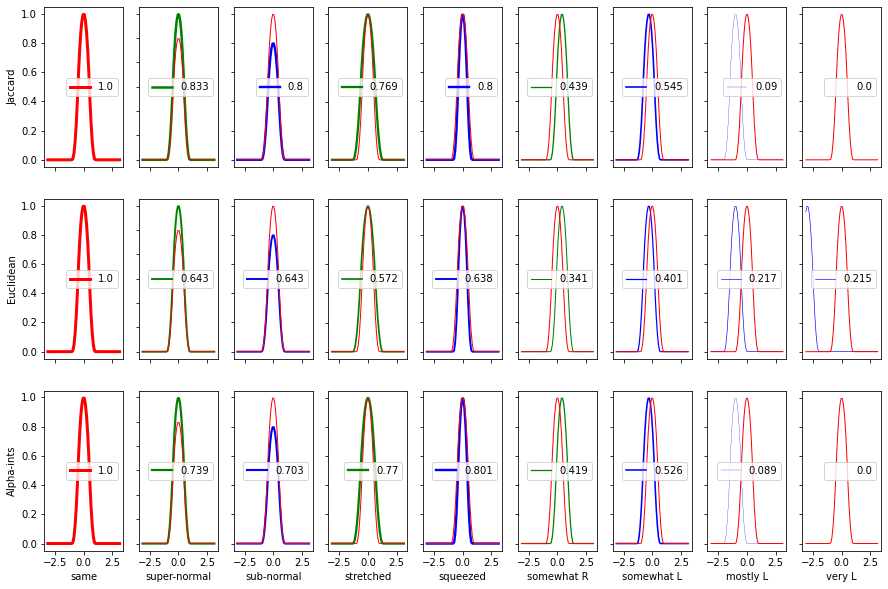

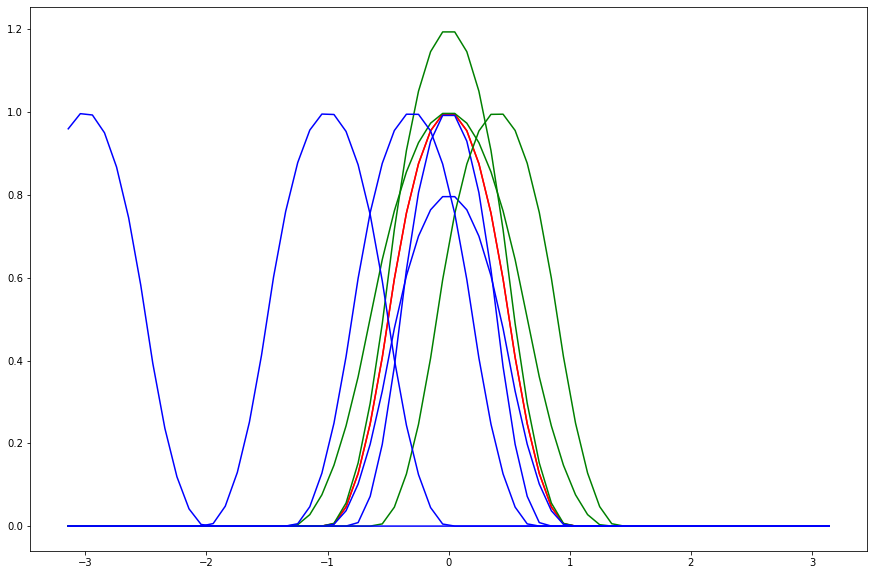

In [6]:
NUM_DIRS = 64    # number of discrete angles between -pi and pi to calculate

bundle_new_params = (1.0, 0.0, 1.0, 0)

bundle_ref_params = [
    bundle_new_params,  # sanity check

     (1.2, 0.0, 1.0, 2),  # super-normal
     (0.8, 0.0, 1.0, 1),  # sub-normal

     (1.0, 0.0, 1.3, 2),  # stretched
     (1.0, 0.0, 0.8, 1),  # squeezed

     (1.0, 0.4, 1.0, 2),  # somewhat RIGHT
     (1.0,-0.3, 1.0, 1),  # somewhat LEFT
     (1.0,-1.0, 1.0, 1),  # mostly LEFT
     (1.0,-3.0, 1.0, 1)   # very LEFT
 ]


# MAIN -------------------------------------------------------------------------

# Initialize Bundle Names
bundle_ref = Bundle(NUM_DIRS)
bundle_new = Bundle(NUM_DIRS)

# Add parameterized data to their respective bundles
bundle_ref.add_t2fs_to_bundle(bundle_ref_params)
bundle_new.add_t1fs_to_bundle(bundle_new_params)

# Plot all T1_T1 similarities using the different metrics
bundle_ref.plot_t1_t1_sim(bundle_new)
plt.show()

# Plot the new input compared to the bundle with similarities
bundle_ref.plot_t1_t2_sim(bundle_new)
plt.show()